# Determining Category of Individuals With the Longest Ford GO-Bike Ride Duration
## by Joshua Oshla Olaku

## Investigation Overview

> In the process of ivestigating this data, I wanted to have insight as to which category of inviduals (whether male or female, subscriber or customer) have the longest ride durations and at which time of the day and day of the week they take this rides, and also to where of from where.


## Dataset Overview

> The Ford Go-Bike dataset consists of the durations in seconds of bike rides taken by riders and also their birth date information, stations riders started from and ended, user type and other information. the dataset initially had 183,412 rows of data which was later cleaned and cutdown to 175,147 rows due to some missing data. The dataset contained the information on users of Ford Go-bike share such as their ride durations, their gender, user type, birth dates, start station and end station information, etc. These were investigated to have an insight as to which category of people usually take the longests rides.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
df = pd.read_csv('201902_fordgobike_tripdata.csv')

In [3]:
# make a copy of the orginial dataset
bikes = df.copy()

In [4]:
# Data wrangling, dealing with null values and inconsistent data as well as inapppropriate datatypes

# locate the entry and change it t0 1987
bikes.loc[27370,'member_birth_year'] = '1987'

# exclude null rows from the dataset
bikes = bikes.loc[~(bikes.member_gender.isna())&~(bikes.member_birth_year.isna())]

bikes.member_birth_year = bikes['member_birth_year'].astype('int') # convert to interger
bikes.bike_id = bikes.bike_id.astype('str') # convert to string
bikes.start_time = bikes.start_time.str.split('.').str[0] # remove the nanoseconds (the decimal point)
bikes.end_time = bikes.end_time.str.split('.').str[0] # remove the values after the decimal point
bikes.start_time = pd.to_datetime(bikes['start_time'], format='%Y-%m-%d %H:%M:%S.%f') # change the column into datetime format
bikes.end_time = pd.to_datetime(bikes['end_time'], format='%Y-%m-%d %H:%M:%S.%f')# change the column into datetime format

# Drop all columns with duration_sec great than 7,000 sec
bikes = bikes[bikes.duration_sec<=7000]

## Distribution of Ride Durations

> After applying a log transformation scale to the durations column of the dataset a bell curve or normal distribution with a slight skew to the right is seen across duration of rides data which takes on a range of values of between 61 seconds to about 6,974 seconds (1 minute to about 2 hours).

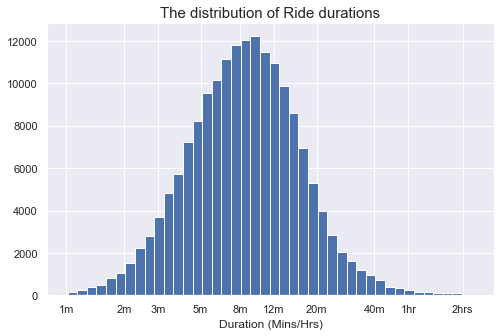

In [5]:
# apply log transformation in order to view the distribution closer because their is a long tail in the distribution
log_binsize = 0.05
bins = 10 ** np.arange(np.log10(bikes['duration_sec'].min()), np.log10(bikes['duration_sec'].max())+log_binsize, log_binsize)
ticks = [60,120, 180, 300, 480, 720, 1200, 2400,3600, 6900]
labels = ['1m','2m','3m', '5m','8m', '12m', '20m', '40m','1hr', '2hrs']

plt.figure(figsize=[8, 5])
plt.hist(data = bikes, x = 'duration_sec', bins = bins)
plt.xscale('log')
plt.xticks(ticks,labels)
plt.xlabel('Duration (Mins/Hrs)')
plt.title('The distribution of Ride durations',fontsize=15)
plt.xlim(right=10000);

## Age distibution of Bike Users

> The age of riders ranged from the age of 20 years to above 70. The ages above 70 were considered as outliers for the sake of this exploration and only those ages between 20 and 70 were included in the analysis. A new column for age was created in the dataset which was calculated from the birth years of the bike users. This plot shows a skew to the right which suggests that there are less number of bike riders with increasing age. The peak or highest number of riders falls around individuals of the ages 26 and 32.

In [6]:
# create new column with age from member_birth_year
bikes['age'] = 2019 - bikes.member_birth_year
bikes.age = bikes.age.astype('int64')
bikes = bikes[bikes.age<70] # remove rows with age over 70 years

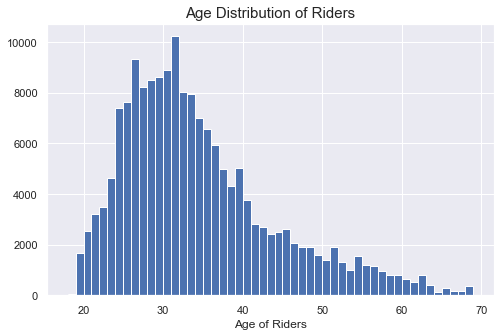

In [7]:
# Plot the age distribution again
binsize = 1
bins = np.arange(bikes['age'].min(), bikes['age'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = bikes, x = 'age',bins=bins)
plt.title('Age Distribution of Riders',fontsize=15)
plt.xlabel('Age of Riders');

In [8]:
# import the datetime library
import datetime as dt
bikes['day'] = bikes['start_time'].dt.day_name() # get the day name
bikes['time_of_day'] = bikes['start_time'].dt.hour # get the hour

# Create the order
ord_dict = {'day': ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']}

for var in ord_dict:
    pd_ver = pd.__version__.split(".")
    if (int(pd_ver[0]) > 0) or (int(pd_ver[1]) >= 21): # v0.21 or later
        ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                    categories = ord_dict[var])
        bikes[var] = bikes[var].astype(ordered_var)
    else: # pre-v0.21
        bikes[var] = bikes[var].astype('category', ordered = True,
                                             categories = ord_dict[var])

## Day and Time vs Duration of Rides
> The days with the longest ride durations appeared to be saturdays and sundays, which were days when the number of rides were fewest. This could be seen in the plot below after applying a logarithmic transformation to the duration's axis. Also the plot below suggests that at 3am and 2pm, the longest rides are usually taken.



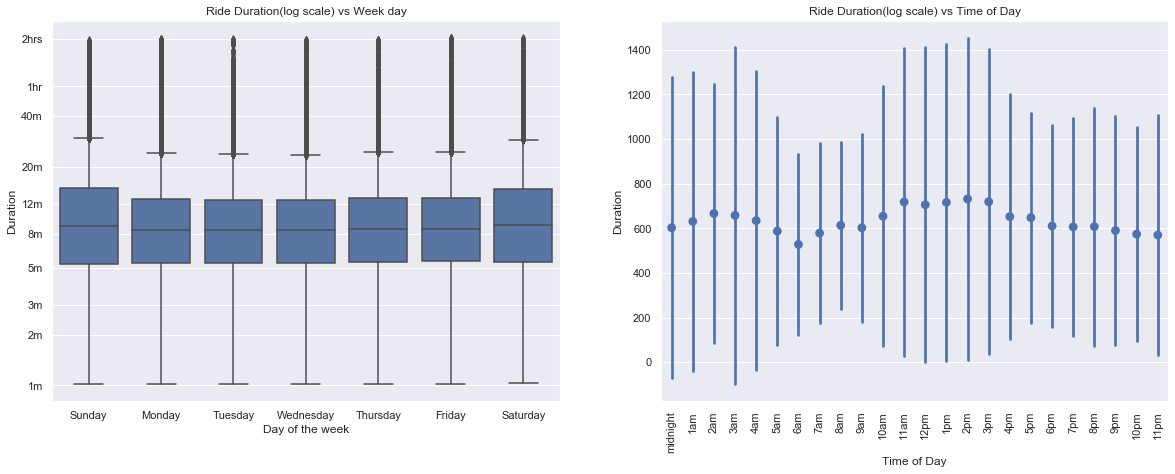

In [9]:
# plot the duration against days of the week and time of day
base_color = sb.color_palette()[0]
ticks = [60,120, 180, 300, 480, 720, 1200, 2400,3600, 6900]
labels = ['1m','2m','3m', '5m','8m', '12m', '20m', '40m','1hr', '2hrs']
plt.figure(figsize=[20,7])

plt.subplot(1,2,1)
sb.boxplot(data=bikes,x='day',y='duration_sec',color=base_color)
plt.yscale('log')
plt.yticks(ticks,labels)
plt.title('Ride Duration(log scale) vs Week day')
plt.xlabel('Day of the week')
plt.ylabel('Duration')

plt.subplot(1,2,2)
x_ticks = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
x_labels = ['midnight','1am','2am','3am','4am','5am','6am','7am','8am','9am','10am','11am','12pm','1pm','2pm',
          '3pm','4pm','5pm','6pm','7pm','8pm','9pm','10pm','11pm']
sb.pointplot(data=bikes, x='time_of_day', y='duration_sec',ci='sd', linestyles="")
plt.xticks(x_ticks,x_labels)
plt.title('Ride Duration(log scale) vs Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Duration')
plt.xticks(rotation=90)
plt.show()

# Ride Duration by Gender and User Type
We can see here that longer ride duration are mostly taken by females who are subscribers. this may be as a result of the fact that females may generally tend to ride bikes more carefully and slowly unlike the men, which may then translate to them taking longer durations getting to their destinations. 

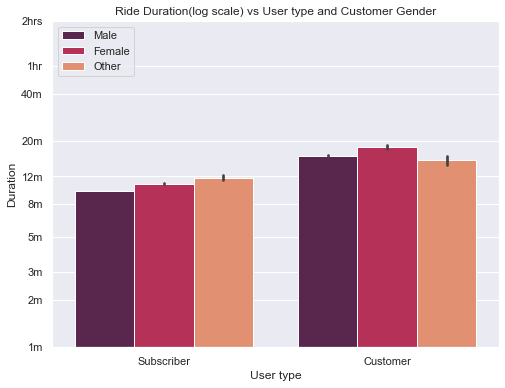

In [10]:
base_color = sb.color_palette()[0]
ticks = [60,120, 180, 300, 480, 720, 1200, 2400,3600, 6900]
labels = ['1m','2m','3m', '5m','8m', '12m', '20m', '40m','1hr', '2hrs']

plt.figure(figsize=[8,6])
sb.barplot(data=bikes, x='user_type', y='duration_sec',hue='member_gender',palette='rocket')
plt.yscale('log')
plt.yticks(ticks,labels)
plt.title('Ride Duration(log scale) vs User type and Customer Gender')
plt.xlabel('User type')
plt.ylabel('Duration')
plt.legend(loc='upper left') # re-arrange legend to upper left position


plt.show()

In [11]:
sub_bikes_data = bikes.loc[(bikes.member_gender != 'Other')] # select only columns with male and female values

# Ride Duration vs Time of Day and Gender

> As seen below, the longest ride durations are associated with females which takes place most often at 2am.

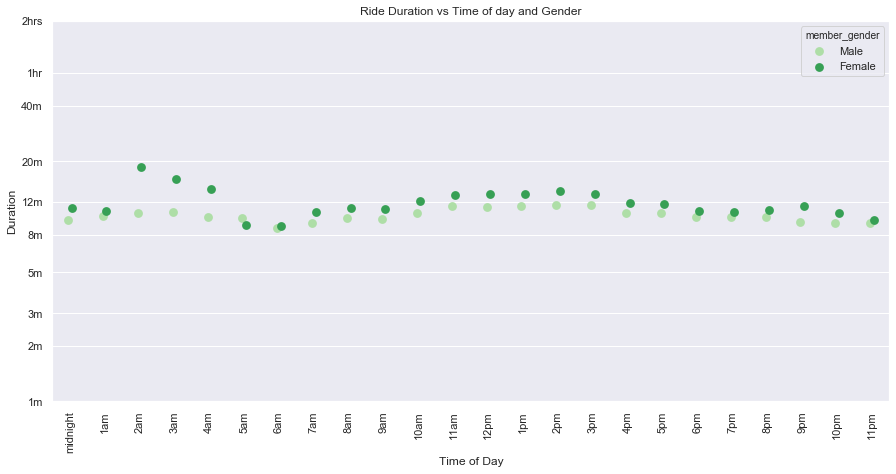

In [14]:
# plot duration against time of day and member gender (male and female)

plt.figure(figsize=[15,7])
x_ticks = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
x_labels = ['midnight','1am','2am','3am','4am','5am','6am','7am','8am','9am','10am','11am','12pm','1pm','2pm',
          '3pm','4pm','5pm','6pm','7pm','8pm','9pm','10pm','11pm']
ticks = [60,120, 180, 300, 480, 720, 1200, 2400,3600, 6900]
labels = ['1m','2m','3m', '5m','8m', '12m', '20m', '40m','1hr', '2hrs']


sb.pointplot(data=sub_bikes_data, x='time_of_day', y='duration_sec',hue='member_gender',
             ci=None, linestyles="",dodge=0.1,palette='Greens')
plt.xticks(x_ticks,x_labels)
plt.xticks(rotation=90)
plt.yscale('log')
plt.yticks(ticks,labels)
plt.title('Ride Duration vs Time of day and Gender')
plt.ylabel('Duration')
plt.xlabel('Time of Day')
plt.show()

In [13]:
# !jupyter nbconvert Part_II_slide_deck_template.ipynb --to slides --post serve --no-input --no-prompt